# Link prediction example: GraphSAGE on GOV.UK data

In [45]:
import networkx as nx
import pandas as pd
import os

import stellargraph as sg
from stellargraph.data import EdgeSplitter
from stellargraph.mapper import GraphSAGELinkGenerator
from stellargraph.layer import GraphSAGE, link_classification, \
                                MeanPoolingAggregator, AttentionalAggregator, MaxPoolingAggregator, MeanAggregator

import keras 
from stellargraph import globalvar
import numpy as np
from datetime import datetime
from keras import backend as K

### Load the GOV.UK network data

In [2]:
DATA_DIR = os.getenv("DATA_DIR")
MODELS_DIR = os.getenv("MODELS_DIR")
content_api = os.path.join(DATA_DIR, "content_api")
edgefile = os.path.join(DATA_DIR, "processed_network", "edges_graphsagetest_feb_01_18_doo_min15weight_wtext.csv.gz")
embeddings_file = os.path.join(content_api, "training_node_data_fixd.csv.gz")

Load the graph from edgelist

In [3]:
edgelist = pd.read_csv(edgefile, compression="gzip")
edgelist["label"] = "go_to"  

In [4]:
edgelist[edgelist.src_node=="/sign-in-universal-credit"]

,src_node,dest_node,weight,src_cid,dest_cid,source,target,label
177,/sign-in-universal-credit,/,46821,b220a437-0d51-4390-9993-63345d0c83ad,f3bbdec2-0e62-4520-a7fd-6ffd5d36e03a,5947,4412,go_to
1694,/sign-in-universal-credit,/jobsearch,29431,b220a437-0d51-4390-9993-63345d0c83ad,a01fcb59-5dc8-4bf5-b06d-dd567a6d2f5f,5947,42642,go_to
1707,/sign-in-universal-credit,/browse/benefits/universal-credit,48087,b220a437-0d51-4390-9993-63345d0c83ad,c17310ef-5797-40ca-a6f9-4afa9ab084f9,5947,51100,go_to
2621,/sign-in-universal-credit,/apply-universal-credit,18489,b220a437-0d51-4390-9993-63345d0c83ad,9a658237-b2d8-43bb-9c72-a81a0fc4029c,5947,56279,go_to
3853,/sign-in-universal-credit,/pip,400,b220a437-0d51-4390-9993-63345d0c83ad,56ffb2a7-f45f-4e6c-bbfe-3d898a3358d8,5947,23704,go_to
3909,/sign-in-universal-credit,/universal-credit,150280,b220a437-0d51-4390-9993-63345d0c83ad,f790dc71-386e-4440-9689-31f94e7ac64d,5947,26857,go_to
5381,/sign-in-universal-credit,/calculate-your-child-maintenance,93,b220a437-0d51-4390-9993-63345d0c83ad,42c2e944-7977-4297-b142-aa9406756dd2,5947,61393,go_to
5700,/sign-in-universal-credit,/browse/benefits,9328,b220a437-0d51-4390-9993-63345d0c83ad,f141fa95-0d79-4aed-8429-ed223a8f106a,5947,23705,go_to
5701,/sign-in-universal-credit,/book-theory-test,208,b220a437-0d51-4390-9993-63345d0c83ad,9922b819-ffcb-4f38-888a-78b898d5e530,5947,62353,go_to
7901,/sign-in-universal-credit,/browse/disabilities,90,b220a437-0d51-4390-9993-63345d0c83ad,77d72043-cbf7-42bf-8b61-e970d854acc4,5947,53194,go_to


In [5]:
# edgelist = edgelist[edgelist.weight>50]

### Load the features and subject for the nodes

In [6]:
node_data = pd.read_csv(embeddings_file, compression="gzip", index_col=0)

In [7]:
node_data.loc[25053].content_id

'305acc88-488e-44ec-8e5a-1a5de7819ba9'

In [8]:
node_data.head(2)

,0,1,2,3,4,5,6,7,8,9,...,503,504,505,506,507,508,509,510,511,content_id
0,0.014993,0.024639,0.058578,0.008009,0.008096,-0.062776,0.059777,0.005778,-0.008614,0.059473,...,0.065568,0.044270,-0.046852,0.035862,-0.043941,0.009524,-0.037714,-0.001525,-0.063660,80f7a69c-5cdc-4bd5-a16c-15d669ba2cc5
1,-0.057149,0.025875,0.049524,0.024483,-0.007833,-0.035528,0.056479,0.009408,-0.044370,-0.040844,...,0.056229,0.056662,-0.038329,0.056141,-0.052406,-0.038637,-0.047737,0.046157,-0.054258,81fb4151-bc2b-49b1-b86e-22f2a1d14208


In [9]:
node_data.shape

(66619, 513)

Define a set of node features that will be used by the model as the difference between the set of all node features and a list of user-defined node attributes to ignore:

In [10]:
# ignore_attr = []
# feature_names = sorted(set(column_names) - set(ignore_attr))
feature_names = node_data.columns[:-1]
feature_names

Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
       ...
       '502', '503', '504', '505', '506', '507', '508', '509', '510', '511'],
      dtype='object', length=512)

We need to convert node features that will be used by the model to numeric values that are required for GraphSAGE input.

In [11]:
node_features = node_data[feature_names].values

### Defined metric: F1 score

In [117]:
def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

### Set up graph from edgelist

In [12]:
G = nx.from_pandas_edgelist(edgelist[['source','target','label']], edge_attr="label")
type(G)

networkx.classes.graph.Graph

Add node data to G:

In [13]:
removed_edges = 0
for nid, f in zip(node_data.index, node_features):
    if nid in G.node.keys():
        G.node[nid][globalvar.TYPE_ATTR_NAME] = "page"  # specify node type
        G.node[nid]["feature"] = f
    else:
        removed_edges+=1
removed_edges

0

From the original graph G, extract a randomly sampled subset of test edges and the reduced graph G_test with the positive test edges removed:

In [46]:
# Define an edge splitter on the original graph G:
edge_splitter_test = EdgeSplitter(G)
# Randomly sample a fraction p=0.1 of all positive links, and same number of negative links, from G, and obtain the
# reduced graph G_test with the sampled links removed:
G_test, edge_ids_test, edge_labels_test = edge_splitter_test.train_test_split(p=0.05`, 
                                                                              method="global", 
                                                                              keep_connected=True)

Removed 1000 edges
Removed 2000 edges
Removed 3000 edges
Removed 4000 edges
Removed 5000 edges
Removed 6000 edges
Removed 7000 edges
Sampled 1000 negative examples
Sampled 2000 negative examples
Sampled 3000 negative examples
Sampled 4000 negative examples
Sampled 5000 negative examples
Sampled 6000 negative examples
Sampled 7000 negative examples
** Sampled 7312 positive and 7312 negative edges. **


The reduced graph G_test, together with the test ground truth set of links (edge_ids_test, edge_labels_test), will be used for testing the model.

Repeat this procedure to obtain the training data for the model. From the reduced graph G_test, extract a randomly sampled subset of train edges and the reduced graph G_train with the positive train edges removed:

In [47]:
# Define an edge splitter on the reduced graph G_test:
edge_splitter_train = EdgeSplitter(G_test)
# Randomly sample a fraction p=0.1 of all positive links, and same number of negative links, from G_test, and obtain the
# reduced graph G_train with the sampled links removed:
G_train, edge_ids_train, edge_labels_train = edge_splitter_train.train_test_split(p=0.1, 
                                                                                  method="global",
                                                                                  keep_connected=True)

Removed 1000 edges
Removed 2000 edges
Removed 3000 edges
Removed 4000 edges
Removed 5000 edges
Removed 6000 edges
Sampled 1000 negative examples
Sampled 2000 negative examples
Sampled 3000 negative examples
Sampled 4000 negative examples
Sampled 5000 negative examples
Sampled 6000 negative examples
** Sampled 6947 positive and 6947 negative edges. **


G_train, together with the train ground truth set of links (edge_ids_train, edge_labels_train), will be used for training the model.

Convert G_train and G_test to StellarGraph objects (undirected, as required by GraphSAGE) for ML:

In [48]:
G_train = sg.StellarGraph(G_train, node_features="feature")
G_test = sg.StellarGraph(G_test, node_features="feature")

Summary of G_train and G_test - note that they have the same set of nodes, only differing in their edge sets:

In [49]:
print(G_train.info())

StellarGraph: Undirected multigraph
 Nodes: 66619, Edges: 131995

 Node types:
  page: [66619]
        Attributes: {'feature'}
    Edge types: page-go_to->page

 Edge types:
    page-go_to->page: [131995]



In [50]:
print(G_test.info())

StellarGraph: Undirected multigraph
 Nodes: 66619, Edges: 138942

 Node types:
  page: [66619]
        Attributes: {'feature'}
    Edge types: page-go_to->page

 Edge types:
    page-go_to->page: [138942]



Next, we create the link mappers for sampling and streaming training and testing data to the model. The link mappers essentially "map" pairs of nodes `(paper1, paper2)` to the input of GraphSAGE: they take minibatches of node pairs, sample 2-hop subgraphs with `(paper1, paper2)` head nodes extracted from those pairs, and feed them, together with the corresponding binary labels indicating whether those pairs represent true or false citation links, to the input layer of the GraphSAGE model, for SGD updates of the model parameters.

Specify the minibatch size (number of node pairs per minibatch) and the number of epochs for training the model:

### Model parameters

In [120]:
batch_size = 64
epochs = 20

In [121]:
# Specify the sizes of 1- and 2-hop neighbour samples for GraphSAGE:
# Length of `num_samples` list defines the number of layers/iterations in the GraphSAGE model
num_samples = [20, 10]

In [122]:
layer_sizes = [128, 128]
assert len(layer_sizes) == len(num_samples)

### Set up train and test set data generators

In [123]:
train_gen = GraphSAGELinkGenerator(G_train, batch_size, num_samples).flow(edge_ids_train, 
                                                                          edge_labels_train, 
                                                                          shuffle=True)
test_gen = GraphSAGELinkGenerator(G_test,  batch_size, num_samples).flow(edge_ids_test, 
                                                                         edge_labels_test)

Build the model: a 2-layer GraphSAGE model acting as node representation learner, with a link classification layer on concatenated `(paper1, paper2)` node embeddings.

GraphSAGE part of the model, with hidden layer sizes of 50 for both GraphSAGE layers, a bias term, and no dropout. (Dropout can be switched on by specifying a positive dropout rate, 0 < dropout < 1)
Note that the length of layer_sizes list must be equal to the length of num_samples, as len(num_samples) defines the number of hops (layers) in the GraphSAGE model.

In [124]:
graphsage = GraphSAGE(layer_sizes=layer_sizes, 
                      generator=train_gen, 
                      bias=True, 
                      dropout=0.3, 
#                       normalize = None,
                      aggregator=AttentionalAggregator)

In [125]:
# Expose input and output sockets of graphsage, for source and destination nodes:
x_inp_src, x_out_src = graphsage.default_model(flatten_output=False)
x_inp_dst, x_out_dst = graphsage.default_model(flatten_output=False)
# re-pack into a list where (source, destination) inputs alternate, for link inputs:
x_inp = [x for ab in zip(x_inp_src, x_inp_dst) for x in ab]
# same for outputs:
x_out = [x_out_src, x_out_dst]

Final link classification layer that takes a pair of node embeddings produced by graphsage, applies a binary operator to them to produce the corresponding link embedding ('ip' for inner product; other options for the binary operator can be seen by running a cell with `?link_classification` in it), and passes it through a dense layer:

### Set up `link_classification` layer and model

In [126]:
prediction = link_classification(output_dim=1, output_act="relu", edge_embedding_method='ip')(x_out)

link_classification: using 'ip' method to combine node embeddings into edge embeddings


Stack the GraphSAGE and prediction layers into a Keras model, and specify the loss

In [127]:
model = keras.Model(inputs=x_inp, outputs=prediction)

model.compile(
        optimizer=keras.optimizers.Adam(lr=1e-3),
#     optimizer= keras.optimizers.SGD(lr=0.01, momentum=0.0, decay=0.0, nesterov=False),
#         optimizer=keras.optimizers.Adadelta(lr=1.0, rho=0.95, epsilon=None, decay=0.0),
        loss=keras.losses.binary_crossentropy,
        metrics=[keras.metrics.binary_accuracy, f1])

Evaluate the initial (untrained) model on the train and test set:

In [128]:
init_train_metrics = model.evaluate_generator(train_gen, verbose=1)

print("\nTrain Set Metrics of the initial (untrained) model:")
for name, val in zip(model.metrics_names, init_train_metrics):
    print("\t{}: {:0.4f}".format(name, val))
print("\n")  

init_test_metrics = model.evaluate_generator(test_gen, verbose=1)

print("\nTest Set Metrics of the initial (untrained) model:")
for name, val in zip(model.metrics_names, init_test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

218/218 [==============================] - 36s 164ms/step

Train Set Metrics of the initial (untrained) model:
	loss: 0.6456
	binary_accuracy: 0.5543
	f1: 0.6894
229/229 [==============================] - 38s 165ms/step

Test Set Metrics of the initial (untrained) model:
	loss: 0.6377
	binary_accuracy: 0.5553
	f1: 0.5007


In [129]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_44 (InputLayer)           (None, 20, 512)      0                                            
__________________________________________________________________________________________________
input_45 (InputLayer)           (None, 200, 512)     0                                            
__________________________________________________________________________________________________
input_47 (InputLayer)           (None, 20, 512)      0                                            
__________________________________________________________________________________________________
input_48 (InputLayer)           (None, 200, 512)     0                                            
__________________________________________________________________________________________________
input_43 (

### Train the model

In [130]:
epochs=40
history = model.fit_generator(
        train_gen,
        epochs=epochs,
        validation_data=test_gen,
        verbose=1
#         shuffle=True
    )

Epoch 1/40
218/218 [==============================] - 92s 421ms/step - loss: 0.2012 - binary_accuracy: 0.9389 - f1: 0.9415 - val_loss: 0.2042 - val_binary_accuracy: 0.9544 - val_f1: 0.4948
Epoch 2/40
218/218 [==============================] - 91s 419ms/step - loss: 0.1506 - binary_accuracy: 0.9600 - f1: 0.9602 - val_loss: 0.1868 - val_binary_accuracy: 0.9575 - val_f1: 0.4959
Epoch 3/40
218/218 [==============================] - 90s 414ms/step - loss: 0.1321 - binary_accuracy: 0.9642 - f1: 0.9643 - val_loss: 0.1876 - val_binary_accuracy: 0.9592 - val_f1: 0.4955
Epoch 4/40
218/218 [==============================] - 90s 415ms/step - loss: 0.1230 - binary_accuracy: 0.9655 - f1: 0.9657 - val_loss: 0.1863 - val_binary_accuracy: 0.9605 - val_f1: 0.4969
Epoch 5/40
218/218 [==============================] - 90s 412ms/step - loss: 0.1259 - binary_accuracy: 0.9657 - f1: 0.9655 - val_loss: 0.1931 - val_binary_accuracy: 0.9599 - val_f1: 0.4954
Epoch 6/40
218/218 [==============================] - 9

In [132]:
filename = "{}_{}_b{}_ns{}-{}_l{}-{}_e{}_{}".format(AttentionalAggregator.__name__,
                                                    "relu",
                                                    batch_size, 
                                                    num_samples[0], num_samples[1], 
                                                    layer_sizes[0],layer_sizes[0],
                                                    epochs,
                                                    datetime.now().strftime("%d%m%y"))+".h5"
filename

'AttentionalAggregator_relu_b64_ns20-10_l128-128_e40_240219.h5'

### Plot metrics
Plot the training history:

In [133]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_history(history):
    metrics = sorted(history.history.keys())
    metrics = metrics[:len(metrics)//2]
    
    f,axs = plt.subplots(1, len(metrics), figsize=(12,4))

    for m,ax in zip(metrics,axs):
        # summarize history for metric m
        ax.plot(history.history[m])
        ax.plot(history.history['val_' + m])
        ax.set_title(m)
        ax.set_ylabel(m)
        ax.set_xlabel('epoch')
        ax.legend(['train', 'test'], loc='upper right')

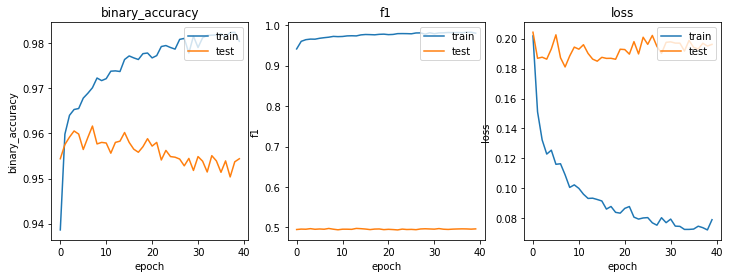

In [134]:
plot_history(history)

Evaluate the trained model on test citation links:

In [135]:
train_metrics = model.evaluate_generator(train_gen, verbose=1)

print("\nTrain Set Metrics of the trained model:")
for name, val in zip(model.metrics_names, train_metrics):
    print("\t{}: {:0.4f}".format(name, val))
    
test_metrics = model.evaluate_generator(test_gen, verbose=1)

print("\nTest Set Metrics of the trained model:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

229/229 [==============================] - 37s 164ms/step

Train Set Metrics of the trained model:
	loss: 0.1336
	binary_accuracy: 0.9806
	f1: 0.9807

Test Set Metrics of the trained model:
	loss: 0.1976
	binary_accuracy: 0.9534
	f1: 0.4961


In [136]:
model.save(os.path.join(MODELS_DIR, filename))